# Synthetic flow matching problem to learn the method

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os

In [17]:
# check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


# 1. Generate synthetic data

We use waveforms of up to 4 combined waves. Targets are the number of waves.

In [2]:

# Global parameters for dataset generation
NUM_POINTS = 100  # Number of points in each waveform
X_RANGE = (-1, 1)  # Spatial range for waveform
MIN_WAVES = 1      # Minimum number of wave components
MAX_WAVES = 4      # Maximum number of wave components
MIN_FREQ = 1.0     # Minimum frequency (ensures at least 1 period in range)
MAX_FREQ = 8.0     # Maximum frequency 
MIN_AMP = 0.3      # Minimum amplitude
MAX_AMP = 1.0      # Maximum amplitude
DATASET_SIZE = 10000  # Total number of waveforms to generate
BATCH_SIZE = 64    # Batch size for data loaders
TEST_SPLIT = 0.2   # Fraction of data for testing

# Create the x-axis points
x = torch.linspace(X_RANGE[0], X_RANGE[1], NUM_POINTS)

def generate_single_waveform():
    """Generate a single waveform with random number of wave components."""
    # Randomly select number of waves
    num_waves = torch.randint(MIN_WAVES, MAX_WAVES + 1, (1,)).item()
    
    # Initialize waveform
    waveform = torch.zeros(NUM_POINTS)
    
    # Generate each wave component
    for _ in range(num_waves):
        # Random amplitude and frequency
        amplitude = torch.rand(1).item() * (MAX_AMP - MIN_AMP) + MIN_AMP
        frequency = torch.rand(1).item() * (MAX_FREQ - MIN_FREQ) + MIN_FREQ
        
        # Random phase shift
        phase = torch.rand(1).item() * 2 * np.pi
        
        # Add wave component
        wave = amplitude * torch.sin(frequency * np.pi * x + phase)
        waveform += wave
    
    return waveform, num_waves

def generate_dataset(size):
    """Generate complete dataset of waveforms and labels."""
    waveforms = []
    labels = []
    
    print(f"Generating {size} waveforms...")
    for i in range(size):
        if (i + 1) % 1000 == 0:
            print(f"Generated {i + 1}/{size} waveforms")
        
        waveform, num_waves = generate_single_waveform()
        waveforms.append(waveform)
        labels.append(num_waves - 1)  # Convert to 0-indexed labels
    
    # Convert to tensors
    waveforms = torch.stack(waveforms)
    labels = torch.tensor(labels, dtype=torch.long)
    
    return waveforms, labels

def plot_waveform(waveform, label=None, title=None, ax=None):
    """Plot a single waveform with optional label and title."""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    
    # Convert to numpy if tensor
    if isinstance(waveform, torch.Tensor):
        waveform_np = waveform.detach().cpu().numpy()
    else:
        waveform_np = waveform
    
    ax.plot(x.numpy(), waveform_np, 'b-', linewidth=2)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('Amplitude')
    
    if title:
        ax.set_title(title)
    elif label is not None:
        # Convert back to 1-indexed for display
        ax.set_title(f'Waveform with {label + 1} wave components')
    
    ax.set_xlim(X_RANGE)
    
    return ax

def plot_dataset_samples(waveforms, labels, num_samples=8):
    """Plot a grid of sample waveforms from the dataset."""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    # Select random samples
    indices = torch.randperm(len(waveforms))[:num_samples]
    
    for i, idx in enumerate(indices):
        plot_waveform(waveforms[idx], labels[idx], ax=axes[i])
    
    plt.tight_layout()
    plt.show()


Starting dataset generation...
Generating 10000 waveforms...
Generated 1000/10000 waveforms
Generated 2000/10000 waveforms
Generated 3000/10000 waveforms
Generated 4000/10000 waveforms
Generated 5000/10000 waveforms
Generated 6000/10000 waveforms
Generated 7000/10000 waveforms
Generated 8000/10000 waveforms
Generated 9000/10000 waveforms
Generated 10000/10000 waveforms

Dataset generated successfully!
Dataset shape: torch.Size([10000, 100])
Labels shape: torch.Size([10000])
Waveform range: [-3.398, 3.590]
Waveforms with 1 waves: 2441 (24.4%)
Waveforms with 2 waves: 2484 (24.8%)
Waveforms with 3 waves: 2537 (25.4%)
Waveforms with 4 waves: 2538 (25.4%)

Train set: 8000 samples
Test set: 2000 samples

Dataset saved to 'data/waveform_dataset.pt'

Plotting sample waveforms...


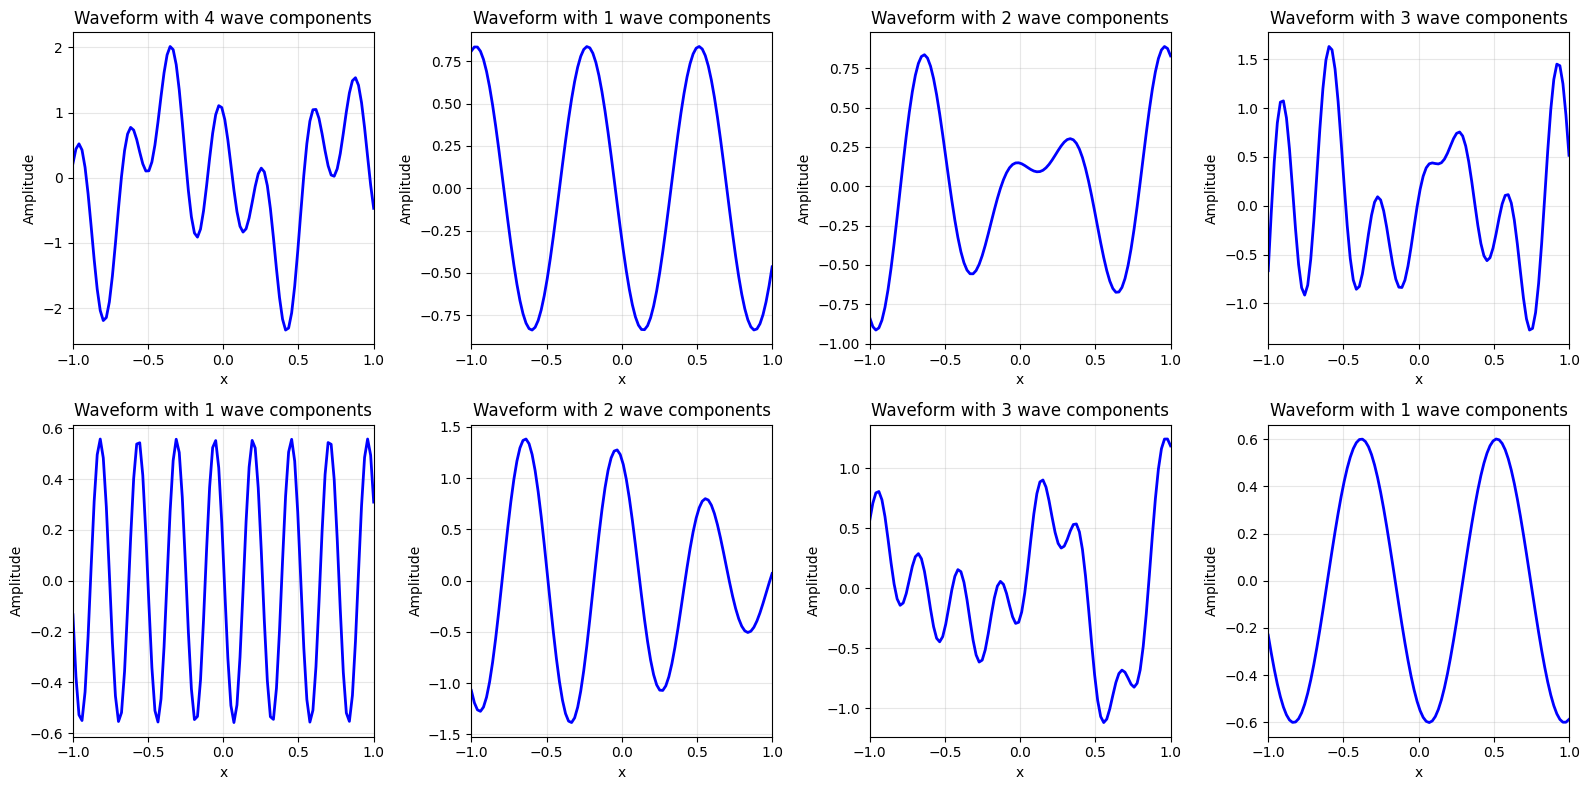

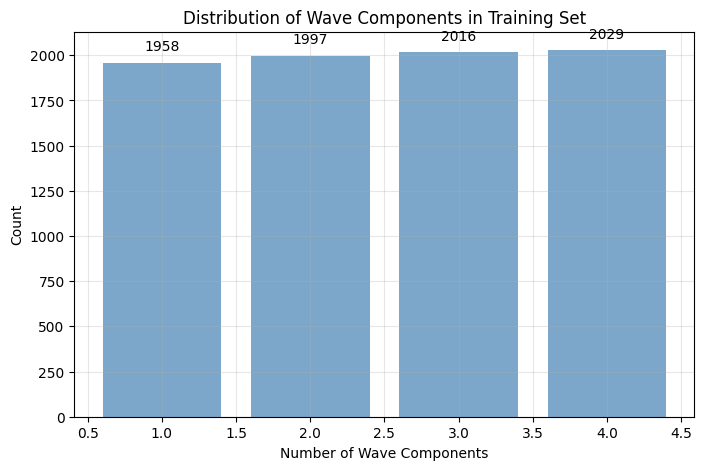


Dataset generation complete! Ready for flow matching model training.


In [3]:
# Generate the dataset
print("Starting dataset generation...")
waveforms, labels = generate_dataset(DATASET_SIZE)

# Print dataset statistics
print(f"\nDataset generated successfully!")
print(f"Dataset shape: {waveforms.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Waveform range: [{waveforms.min():.3f}, {waveforms.max():.3f}]")

# Print label distribution
for i in range(MAX_WAVES):
    count = (labels == i).sum().item()
    print(f"Waveforms with {i+1} waves: {count} ({count/DATASET_SIZE*100:.1f}%)")

# Split into train and test sets
n_test = int(DATASET_SIZE * TEST_SPLIT)
n_train = DATASET_SIZE - n_test

# Random split
indices = torch.randperm(DATASET_SIZE)
train_indices = indices[:n_train]
test_indices = indices[n_train:]

train_waveforms = waveforms[train_indices]
train_labels = labels[train_indices]
test_waveforms = waveforms[test_indices]
test_labels = labels[test_indices]

print(f"\nTrain set: {train_waveforms.shape[0]} samples")
print(f"Test set: {test_waveforms.shape[0]} samples")

# Save dataset to disk
os.makedirs('data', exist_ok=True)
torch.save({
    'train_waveforms': train_waveforms,
    'train_labels': train_labels,
    'test_waveforms': test_waveforms,
    'test_labels': test_labels,
    'x_axis': x,
    'generation_params': {
        'num_points': NUM_POINTS,
        'x_range': X_RANGE,
        'min_waves': MIN_WAVES,
        'max_waves': MAX_WAVES,
        'min_freq': MIN_FREQ,
        'max_freq': MAX_FREQ,
        'min_amp': MIN_AMP,
        'max_amp': MAX_AMP
    }
}, 'data/waveform_dataset.pt')

print(f"\nDataset saved to 'data/waveform_dataset.pt'")

# Plot some sample waveforms
print(f"\nPlotting sample waveforms...")
plot_dataset_samples(train_waveforms, train_labels)

# Plot distribution of wave counts
plt.figure(figsize=(8, 5))
wave_counts = [i+1 for i in range(MAX_WAVES)]
label_counts = [(train_labels == i).sum().item() for i in range(MAX_WAVES)]
plt.bar(wave_counts, label_counts, alpha=0.7, color='steelblue')
plt.xlabel('Number of Wave Components')
plt.ylabel('Count')
plt.title('Distribution of Wave Components in Training Set')
plt.grid(True, alpha=0.3)
for i, count in enumerate(label_counts):
    plt.text(i+1, count + 50, str(count), ha='center', va='bottom')
plt.show()

print(f"\nDataset generation complete! Ready for flow matching model training.")

## 2. Flow matchin model

Using Unet style convolution

In [9]:
# load datra from disk
data = torch.load('data/waveform_dataset.pt')
train_waveforms = data['train_waveforms']
train_labels = data['train_labels']
test_waveforms = data['test_waveforms']
test_labels = data['test_labels']

dataset = TensorDataset(train_waveforms, train_labels)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(test_waveforms, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SinusoidalTimeEmbedding(nn.Module):
    """
    Sinusoidal time embedding for flow matching models.
    
    Creates rich time representations using sinusoidal functions at multiple frequencies.
    This helps the model distinguish between different stages of the flow from t=0 to t=1.
    
    Args:
        dim (int): Dimension of the time embedding
        max_period (float): Maximum period for the sinusoidal embeddings
    
    Inputs:
        t: Time tensor of shape (batch_size,) with values in [0, 1]
    
    Outputs:
        embedding: Time embedding tensor of shape (batch_size, dim)
    """
    def __init__(self, dim, max_period=10000):
        super().__init__()
        self.dim = dim
        self.max_period = max_period
        
    def forward(self, t):
        """
        Args:
            t: Time tensor (batch_size,) with values in [0, 1]
            
        Returns:
            Time embeddings (batch_size, dim)
        """
        device = t.device
        half_dim = self.dim // 2
        
        # Create frequency schedule
        freqs = torch.exp(
            -math.log(self.max_period) * torch.arange(start=0, end=half_dim, dtype=torch.float32) / half_dim
        ).to(device)
        
        # Compute sinusoidal embeddings
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        
        # Handle odd dimensions
        if self.dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
            
        return embedding

class ConvBlock1D(nn.Module):
    """
    1D Convolutional block with GroupNorm, SiLU activation, and time embedding injection.
    
    This is a building block for the U-Net that processes 1D waveform data with
    time-conditioning for flow matching.
    
    Args:
        in_channels (int): Number of input channels
        out_channels (int): Number of output channels  
        time_emb_dim (int): Dimension of time embedding
        kernel_size (int): Convolution kernel size
        groups (int): Number of groups for GroupNorm (set to 1 for LayerNorm-like behavior)
        
    Inputs:
        x: Input tensor of shape (batch_size, in_channels, sequence_length)
        time_emb: Time embedding of shape (batch_size, time_emb_dim)
        
    Outputs:
        x: Output tensor of shape (batch_size, out_channels, sequence_length)
    """
    def __init__(self, in_channels, out_channels, time_emb_dim, kernel_size=3, groups=8):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.norm1 = nn.GroupNorm(min(groups, out_channels), out_channels)
        self.act1 = nn.SiLU()
        
        # Time embedding projection
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.norm2 = nn.GroupNorm(min(groups, out_channels), out_channels)
        self.act2 = nn.SiLU()
        
        # Residual connection
        self.residual = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        
    def forward(self, x, time_emb):
        """
        Args:
            x: (batch_size, in_channels, sequence_length)
            time_emb: (batch_size, time_emb_dim)
            
        Returns:
            (batch_size, out_channels, sequence_length)
        """
        residual = self.residual(x)
        
        # First conv block
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act1(h)
        
        # Add time embedding
        time_proj = self.time_mlp(time_emb)[:, :, None]  # (batch, out_channels, 1)
        h = h + time_proj
        
        # Second conv block
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act2(h)
        
        # Residual connection
        return h + residual

class DownBlock1D(nn.Module):
    """
    Downsampling block for 1D U-Net.
    
    Combines ConvBlock1D with strided convolution for downsampling.
    Used in the encoder path of the U-Net.
    
    Args:
        in_channels (int): Number of input channels
        out_channels (int): Number of output channels
        time_emb_dim (int): Dimension of time embedding
        downsample (bool): Whether to apply downsampling
        
    Inputs:
        x: Input tensor of shape (batch_size, in_channels, sequence_length)
        time_emb: Time embedding of shape (batch_size, time_emb_dim)
        
    Outputs:
        x: Output tensor of shape (batch_size, out_channels, sequence_length // 2) if downsample else same length
    """
    def __init__(self, in_channels, out_channels, time_emb_dim, downsample=True):
        super().__init__()
        
        self.conv_block = ConvBlock1D(in_channels, out_channels, time_emb_dim)
        
        if downsample:
            self.downsample = nn.Conv1d(out_channels, out_channels, 3, stride=2, padding=1)
        else:
            self.downsample = nn.Identity()
            
    def forward(self, x, time_emb):
        """
        Args:
            x: (batch_size, in_channels, sequence_length)
            time_emb: (batch_size, time_emb_dim)
            
        Returns:
            (batch_size, out_channels, downsampled_length)
        """
        x = self.conv_block(x, time_emb)
        x = self.downsample(x)
        return x

class UpBlock1D(nn.Module):
    """
    Upsampling block for 1D U-Net.
    
    Combines upsampling with ConvBlock1D and skip connections.
    Used in the decoder path of the U-Net.
    
    Args:
        in_channels (int): Number of input channels (from previous layer)
        skip_channels (int): Number of channels from skip connection
        out_channels (int): Number of output channels
        time_emb_dim (int): Dimension of time embedding
        upsample (bool): Whether to apply upsampling
        
    Inputs:
        x: Input tensor of shape (batch_size, in_channels, sequence_length)
        skip: Skip connection tensor of shape (batch_size, skip_channels, target_length)
        time_emb: Time embedding of shape (batch_size, time_emb_dim)
        
    Outputs:
        x: Output tensor of shape (batch_size, out_channels, target_length)
    """
    def __init__(self, in_channels, skip_channels, out_channels, time_emb_dim, upsample=True):
        super().__init__()
        
        if upsample:
            self.upsample = nn.ConvTranspose1d(in_channels, in_channels, 4, stride=2, padding=1)
        else:
            self.upsample = nn.Identity()
            
        self.conv_block = ConvBlock1D(in_channels + skip_channels, out_channels, time_emb_dim)
        
    def forward(self, x, skip, time_emb):
        """
        Args:
            x: (batch_size, in_channels, sequence_length)  
            skip: (batch_size, skip_channels, target_length)
            time_emb: (batch_size, time_emb_dim)
            
        Returns:
            (batch_size, out_channels, target_length)
        """
        x = self.upsample(x)
        
        # Handle potential size mismatch from upsampling
        if x.shape[-1] != skip.shape[-1]:
            x = F.interpolate(x, size=skip.shape[-1], mode='linear', align_corners=False)
            
        # Concatenate skip connection
        x = torch.cat([x, skip], dim=1)
        
        # Apply conv block
        x = self.conv_block(x, time_emb)
        return x

class FlowMatchingUNet1D(nn.Module):
    """
    1D U-Net for flow matching on waveform data.
    
    This model learns a velocity field v_θ(x_t, t) that predicts how each point
    in a waveform should move at time t during the flow from noise to data.
    
    Architecture:
    - Encoder: Downsampling blocks that extract hierarchical features
    - Bottleneck: Processing at the lowest resolution  
    - Decoder: Upsampling blocks with skip connections that generate velocity field
    - Time conditioning: Injected at every level via time embeddings
    
    Args:
        input_dim (int): Dimension of input waveforms (default: 100)
        time_emb_dim (int): Dimension of time embeddings (default: 128)
        base_channels (int): Base number of channels, doubled at each downsampling level (default: 64)
        channel_multipliers (tuple): Channel multipliers for each resolution level (default: (1, 2, 4, 8))
        
    Inputs:
        x_t: Noisy waveforms at time t, shape (batch_size, input_dim)
        t: Time values in [0, 1], shape (batch_size,)
        
    Outputs:
        velocity: Predicted velocity field, shape (batch_size, input_dim)
                 Each component indicates how that waveform point should change
    """
    def __init__(self, input_dim=100, time_emb_dim=128, base_channels=64, channel_multipliers=(1, 2, 4, 8)):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_emb_dim = time_emb_dim
        
        # Time embedding
        self.time_embedding = SinusoidalTimeEmbedding(time_emb_dim)
        
        # Initial projection from 1D waveform to multi-channel representation
        self.input_proj = nn.Conv1d(1, base_channels * channel_multipliers[0], 7, padding=3)
        
        # Encoder (downsampling path)
        self.encoder_blocks = nn.ModuleList()
        in_ch = base_channels * channel_multipliers[0]
        self.encoder_channels = [in_ch]  # Track channels for skip connections
        
        for i, mult in enumerate(channel_multipliers[1:]):
            out_ch = base_channels * mult
            self.encoder_blocks.append(
                DownBlock1D(in_ch, out_ch, time_emb_dim, downsample=True)
            )
            self.encoder_channels.append(out_ch)
            in_ch = out_ch
            
        # Bottleneck
        self.bottleneck = ConvBlock1D(in_ch, in_ch, time_emb_dim)
        
        # Decoder (upsampling path)
        self.decoder_blocks = nn.ModuleList()
        for i, mult in enumerate(reversed(channel_multipliers[:-1])):
            skip_ch = self.encoder_channels[-(i+2)]  # Corresponding encoder channel
            out_ch = base_channels * mult
            
            self.decoder_blocks.append(
                UpBlock1D(in_ch, skip_ch, out_ch, time_emb_dim, upsample=True)
            )
            in_ch = out_ch
            
        # Final output projection to velocity field
        self.output_proj = nn.Sequential(
            nn.Conv1d(in_ch, in_ch // 2, 3, padding=1),
            nn.GroupNorm(min(8, in_ch // 2), in_ch // 2),
            nn.SiLU(),
            nn.Conv1d(in_ch // 2, 1, 3, padding=1)  # Output single channel
        )
        
    def forward(self, x_t, t):
        """
        Forward pass of the flow matching U-Net.
        
        Args:
            x_t: Current waveforms at time t
                 Shape: (batch_size, input_dim)
                 Values: Interpolated between noise and target data
                 
            t: Current time values  
               Shape: (batch_size,)
               Values: Float values in [0, 1] where 0=noise, 1=data
               
        Returns:
            velocity: Predicted velocity field
                     Shape: (batch_size, input_dim) 
                     Values: How each waveform point should change at time t
                     
        Flow matching interpretation:
        - At t=0: x_t is pure noise, velocity should point toward data
        - At t=1: x_t is clean data, velocity should be near zero  
        - At t=0.5: x_t is halfway interpolated, velocity guides remaining transformation
        """
        batch_size = x_t.shape[0]
        
        # Generate time embeddings
        time_emb = self.time_embedding(t)  # (batch_size, time_emb_dim)
        
        # Project input to multi-channel representation
        x = x_t.unsqueeze(1)  # (batch_size, 1, input_dim)
        x = self.input_proj(x)  # (batch_size, base_channels, input_dim)
        
        # Encoder path - store skip connections
        skip_connections = [x]
        
        for block in self.encoder_blocks:
            x = block(x, time_emb)
            skip_connections.append(x)
            
        # Bottleneck processing
        x = self.bottleneck(x, time_emb)
        
        # Decoder path - use skip connections in reverse order
        skip_connections = skip_connections[:-1]  # Remove last (it's the current x)
        
        for i, block in enumerate(self.decoder_blocks):
            skip = skip_connections[-(i+1)]  # Get corresponding skip connection
            x = block(x, skip, time_emb)
            
        # Final projection to velocity field
        velocity = self.output_proj(x)  # (batch_size, 1, input_dim)
        velocity = velocity.squeeze(1)  # (batch_size, input_dim)
        
        return velocity
    
    def sample(self, batch_size, num_steps=100, device=None):
        """
        Generate samples by integrating the learned velocity field from noise to data.
        
        This implements the forward flow: starting from Gaussian noise, we follow
        the learned velocity field to generate realistic waveforms.
        
        Args:
            batch_size (int): Number of samples to generate
            num_steps (int): Number of integration steps (higher = more accurate)
            device: Device to generate samples on
            
        Returns:
            samples: Generated waveforms of shape (batch_size, input_dim)
            trajectory: Full trajectory of shape (num_steps+1, batch_size, input_dim) 
                       showing evolution from noise to data
        """
        if device is None:
            device = next(self.parameters()).device
            
        # Start from Gaussian noise
        x = torch.randn(batch_size, self.input_dim, device=device)
        
        # Store trajectory for visualization
        trajectory = [x.clone()]
        
        dt = 1.0 / num_steps
        
        self.eval()
        with torch.no_grad():
            for step in range(num_steps):
                t = torch.full((batch_size,), step * dt, device=device)
                
                # Predict velocity at current time and position
                velocity = self.forward(x, t)
                
                # Euler integration step
                x = x + dt * velocity
                trajectory.append(x.clone())
                
        return x, torch.stack(trajectory)

def count_parameters(model):
    """
    Count the total number of trainable parameters in the model.
    
    Args:
        model: PyTorch model
        
    Returns:
        int: Total number of trainable parameters
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
model = FlowMatchingUNet1D(
    input_dim=NUM_POINTS,
    time_emb_dim=32, base_channels=64,
    channel_multipliers=(1, 2, 4, 8))

In [6]:
model

FlowMatchingUNet1D(
  (time_embedding): SinusoidalTimeEmbedding()
  (input_proj): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (encoder_blocks): ModuleList(
    (0): DownBlock1D(
      (conv_block): ConvBlock1D(
        (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (norm1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (act1): SiLU()
        (time_mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=32, out_features=128, bias=True)
        )
        (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (norm2): GroupNorm(8, 128, eps=1e-05, affine=True)
        (act2): SiLU()
        (residual): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      )
      (downsample): Conv1d(128, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    )
    (1): DownBlock1D(
      (conv_block): ConvBlock1D(
        (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (norm1): GroupN

In [8]:
from torchview import draw_graph

batch_size = 2
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(
    model,
    input_size=[(batch_size, NUM_POINTS),(batch_size,)],
    device='mps')
model_graph.visual_graph

RuntimeError: Failed to run torchgraph see error message

In [10]:
first_batch = next(iter(train_loader))

In [13]:
x_t = first_batch[0]
t = torch.zeros(first_batch[0].shape[0], device=x_t.device)  # Assume t=0 for initial noise

In [20]:
x_t = x_t.to(device)
t = t.to(device)

In [22]:
t.device

device(type='mps', index=0)

In [23]:
model(x_t, t)

NotImplementedError: The operator 'aten::upsample_linear1d.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.